# Visualizing daily cases of COVID-19 in the United States
Scroll to the bottom to view the map result

In [1]:
import csv
import requests
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import matplotlib.lines as mlines
import matplotlib.offsetbox as offsetbox
import formatting as form

plt.close('all')

In [2]:
CSV_URL = 'https://covidtracking.com/api/v1/states/daily.csv'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = pd.read_csv(StringIO(decoded_content))
    df = pd.DataFrame(cr)

In [3]:
# Convert date integers to DateTime
date = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
dataType = 'positiveIncrease'
#Applied in a new DataFrame
df = pd.DataFrame({'date':date, 'state':df['state'], dataType:df[dataType]})

In [4]:
df.groupby('date')

In [5]:
#List containing every state abbreviation (includes DC)
stateNames = ['WA', 'ID', 'MT', 'ND', 'MN','WI','MI','NY','VT', 'NH','ME',
             'OR','WY', 'SD', 'IA', 'IL', 'IN', 'OH', 'PA', 'MA', 'RI', 'CT', 'NJ',
             'DE', 'MD', 'DC', 'CA', 'NV', 'UT', 'CO', 'NE', 'MO', 'KS', 'OK', 'NM', 
              'AZ', 'TX', 'LA', 'AR', 'TN', 'MS', 'AL', 'KY', 'WV', 'VA', 'NC',
             'SC', 'GA', 'FL', 'AK', 'HI']

In [6]:
# Create a new DataFrame with each state as a column and their positiveIncreases as rows, indexed by date.
# I'm sure there's a cleaner way to do this...
dfstates = []

for name in stateNames:
    sel = df[(df['state']==name)]
    sel.index=sel['date']
    dfstates.insert(len(dfstates), sel)
dfgroup = pd.DataFrame()

for d in dfstates:
    dfgroup[d['state'][0]] = d[dataType]

In [7]:
#Compares weekly totals to the previous week for 7 weeks. Returns how many consecutive weeks saw a relative increase to the previous week.
def consecutiveWeeksIncreased(state):
    weeks = 0
    prev = 999999
    for week in range(7):
        thisWeekSum = sumRange(state, weeks * 7, weeks * 7 + 8)
        if thisWeekSum <= prev:
            prev = thisWeekSum
            weeks += 1
        else:
            return weeks
    return weeks - 1

In [8]:
avgIncrease = 0
for state in dfgroup:
    avgIncrease += dfgroup[state][0]
avgIncrease /= dfgroup.shape[1]
avgIncrease = int(avgIncrease)
avgIncrease

814

In [9]:
#Create a subplot for the state by state abbreviation
def do_plot(ax, name):
    
    #Get color pair based on how many weeks the state has seen an increase in total cases
    weeksClimbing = consecutiveWeeksIncreased(dfgroup[name])
    colors = form.getContrastingColors(weeksClimbing)
    faceColor = colors[0]
    infoColor = colors[1]
    
    #Set the face color
    ax.set_facecolor(faceColor)
    
    #plot the data for this state
    ax.plot(dfgroup[name], color=(infoColor), linewidth=1)
    
    #remove the labels, grids & ticks for a cleaner look
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    #Display the state abbreviation title
    ax.set_title(name,horizontalalignment='left', color=(infoColor), fontweight="bold", fontsize=14, x=0.025, y=.775)
    
    #Display a subtle border
    form.formatBorder(ax)
    
    #Display a '100 new cases' threshold for scale
    ax.axhline(y=avgIncrease, color='r', linestyle='-', linewidth=.5)

    #Latest increase    
    lastChange = form.getLastIncreaseChange(name, dfgroup)
    changeNote = '(' + form.getIncreaseSign(lastChange) + str(lastChange) + ')'
    box = dict(boxstyle='round,pad=0.1', fc=faceColor, ec=faceColor, alpha=0.7)
    ax.annotate(s= '+'+str(int(dfgroup[name][0])), xy=(.025, 0.7), xycoords='axes fraction', fontsize=11, color=infoColor, bbox = box)
    
    #Latest increase vs previous day
    ax.annotate(s= changeNote, xy=(.025, 0.581), xycoords='axes fraction', fontsize=11, color=form.getIncreaseColor(lastChange), bbox = box)
    
    #Subtle label background (in progress)
    #box = offsetbox.AnchoredOffsetbox()

In [10]:
# Returns the sum of contents within a list's range
def sumRange(L,a,b):                                                                                                                                                                                                
    sum = 0                                                                                                                                                                                                         
    for i in range(a,b+1,1):                                                                                                                                                                                        
        sum += L[i]                                                                                                                                                                                                  
    return sum      

In [11]:
def invLerp(a, b, t):
    return (float(t)-float(a)) / (float(b)-float(a))

In [12]:
# Add a state to the grid by abbreviation
def add_state(figure, stateName, grid):
    state = figure.add_subplot(grid)
    do_plot(state, stateName)
    return state

In [13]:
#'Last updated on' string
now = datetime.now()
dt_string = now.strftime("%m/%d/%Y %H:%M:%S")
dt_string = "Last updated: " + dt_string + " PST"

In [14]:
#Subtitle - date range
lastDate = date[0]
lastYear = lastDate.year
lastDate = lastDate = lastDate.month_name() + ' ' + str(lastDate.day)
shape = date.shape
firstDate = date[shape[0]-1]
firstYear = firstDate.year
firstDate = firstDate.month_name() + ' ' + str(firstDate.day)
dateRangeString = 'From ' + firstDate + ', ' + str(firstYear) + ' to ' + lastDate + ', ' + str(lastYear) 

In [15]:
#Adding groups of states in vertical columns using a list of abbreviation strings
def add_column(fig, names, column, grid):
    row = 0
    for name in names:
        if(name == ""):
            row+=1
            continue
        else:
            add_state(fig, name, grid[row, column])
            row+=1

<ipython-input-16-d97f84e04f9b>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(.5, .822, s=dateRangeString, color = form.titleColor, horizontalAlignment = 'center')
<ipython-input-9-c73b465277ed>:35: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s= '+'+str(int(dfgroup[name][0])), xy=(.025, 0.7), xycoords='axes fraction', fontsize=11, color=infoColor, bbox = box)
<ipython-input-9-c73b465277ed>:38: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s= changeNote, xy=(.025, 0.581), xycoords='axes fraction', fontsize=11, color=form.getIncreaseColor(lastChange), bbox = box)
d:\Git\covid_tracking_us\formatting.py:63

Text(0.975, 0.25, 'Data collected via The COVID Tracking Project')

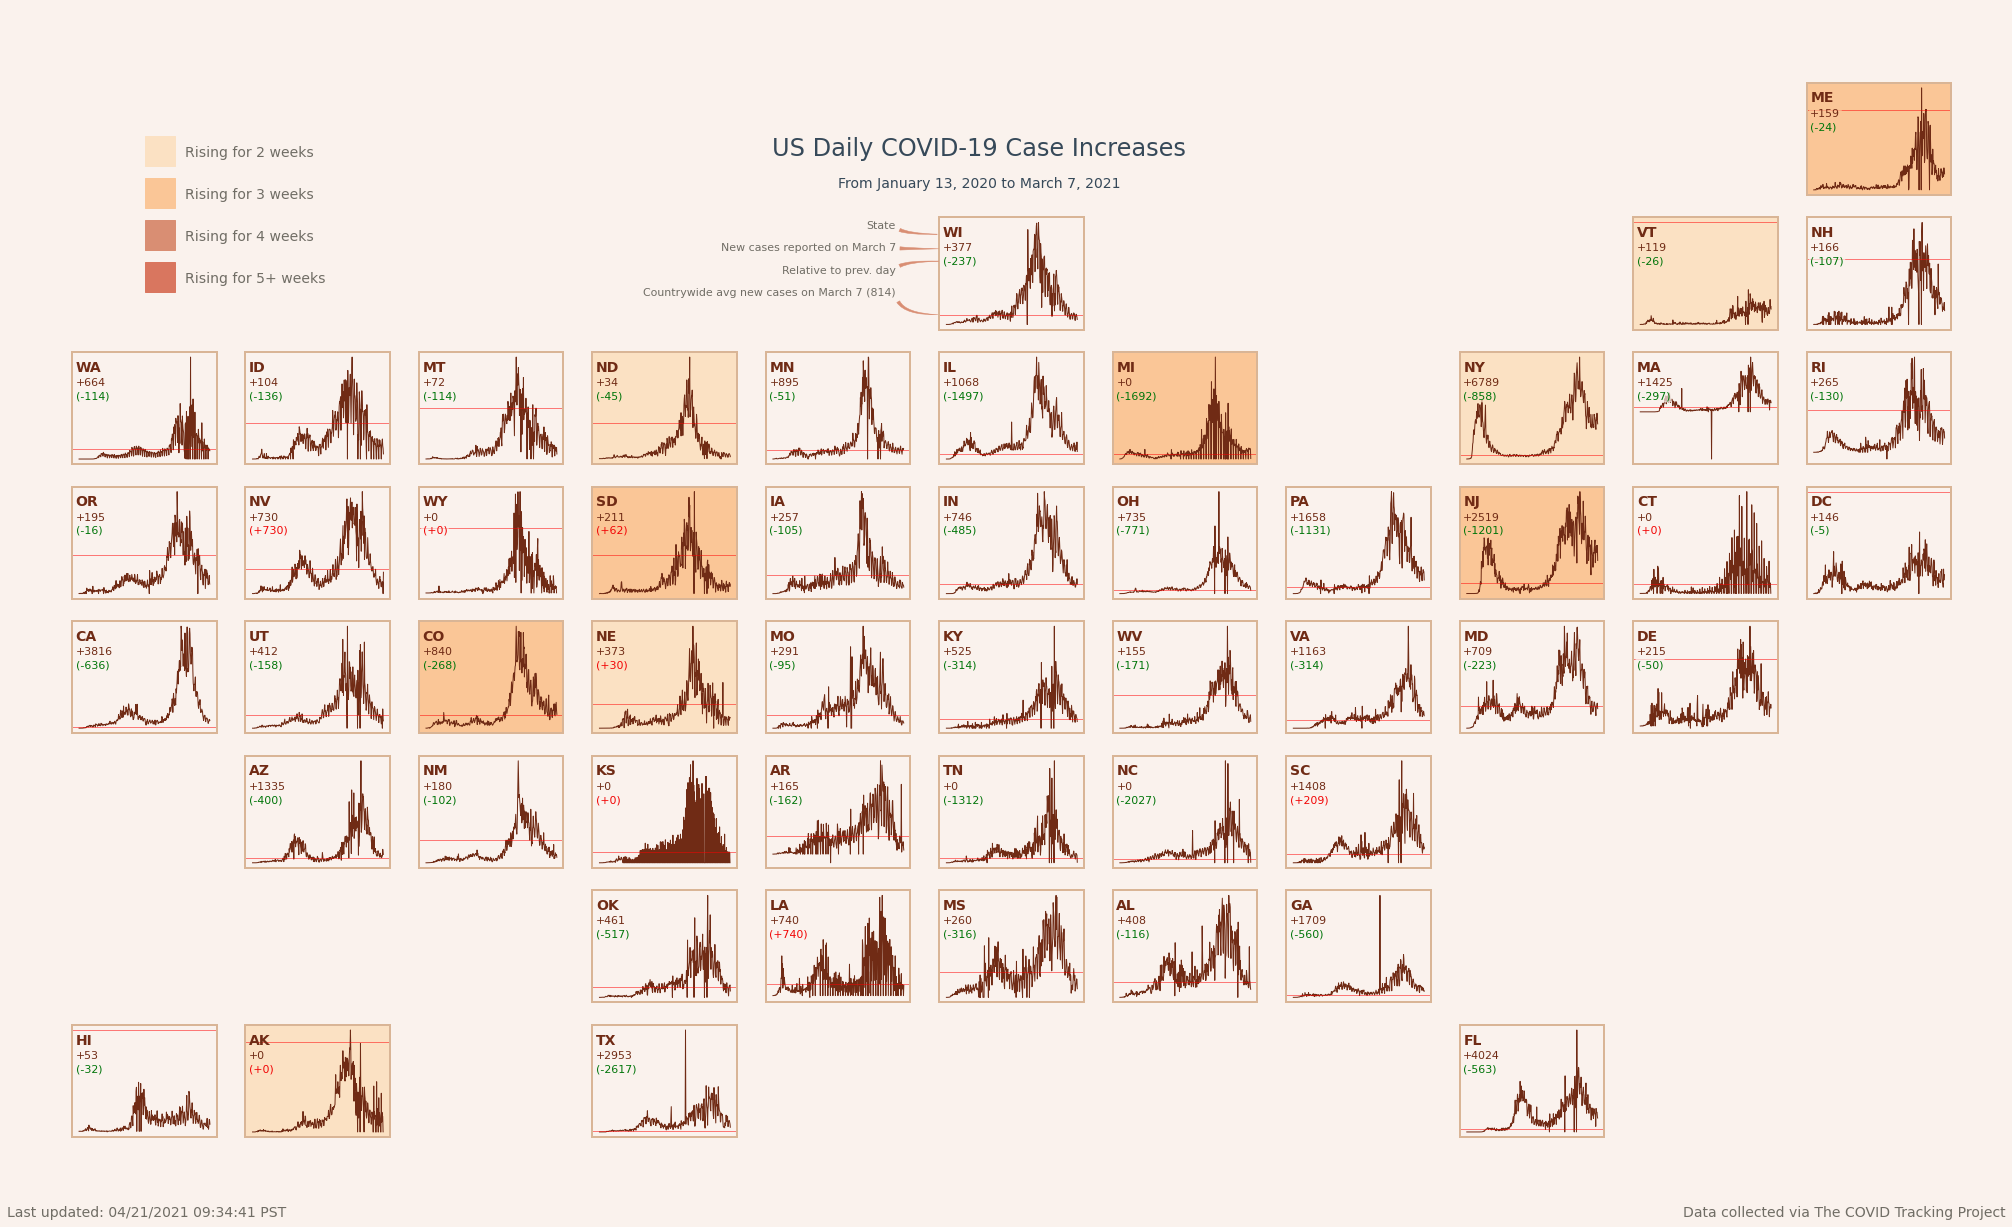

In [16]:
# Plot setup
plt.style.use('fivethirtyeight')

g = gridspec.GridSpec(11, 11)

fig = plt.figure(figsize=(30,25), facecolor=form.light)

#Title
fig.suptitle('US Daily COVID-19 Case Increases', y=0.85, fontsize=24, color=form.titleColor)
fig.text(.5, .822, s=dateRangeString, color = form.titleColor, horizontalAlignment = 'center')

#'Last updated on'
fig.text(x=.05, y=.25, s=dt_string, color=form.labelColor)
x = .1
y =.75

#Create legend
#redline = mlines.Line2D([], [], color=form.redBar, marker='', markersize=15, label='100 new cases per day')
twoWeeksIncrease = mlines.Line2D([],[], color = form.medLight, marker='s',markersize=30, label='Rising for 2 weeks')
threeWeeksIncrease = mlines.Line2D([],[], color = form.medium, marker='s',markersize=30, label='Rising for 3 weeks')
fourWeeksIncrease = mlines.Line2D([],[], color = form.medDark, marker='s',markersize=30, label='Rising for 4 weeks')
fiveWeeksIncrease = mlines.Line2D([],[],  color = form.medDark2, marker='s',markersize=30, label='Rising for 5+ weeks')
legend = fig.legend(handles=[twoWeeksIncrease, threeWeeksIncrease, fourWeeksIncrease, fiveWeeksIncrease], loc='upper left',borderaxespad=10, framealpha=0, labelspacing=2)

for t in legend.get_texts():
    t.set_color(form.labelColor)
    
# Create state subplots
add_column(fig, ['', '', 'WA', 'OR', 'CA',  '', '', 'HI'], 0, g)
add_column(fig, ['', '', 'ID', 'NV', 'UT', 'AZ', '', 'AK'], 1, g)
add_column(fig, ['','', 'MT', 'WY', 'CO', 'NM'], 2, g)
add_column(fig, ['','','ND','SD', 'NE', 'KS', 'OK', 'TX'], 3, g)
add_column(fig, ['', '', 'MN', 'IA', 'MO', 'AR', 'LA'], 4, g)
add_column(fig, ['', 'WI', 'IL', 'IN', 'KY', 'TN', 'MS'], 5, g)
add_column(fig, ['', '','MI', 'OH', 'WV', 'NC', 'AL'], 6, g)
add_column(fig, ['', '', '', 'PA', 'VA', 'SC', 'GA'], 7, g)
add_column(fig, ['', '', 'NY', 'NJ', 'MD', '', '', 'FL'], 8, g)
add_column(fig, ['', 'VT', 'MA', 'CT', 'DE'], 9, g)
add_column(fig, ['ME', 'NH', 'RI', 'DC'], 10, g)

#create guide info

#WI's ax
ax = fig.axes[24]

form.createLabelGuide(ax, 'State', (0, .85), 'axes fraction', .9)
form.createLabelGuide(ax, 'New cases reported on ' + lastDate, (0.01, .72), 'axes fraction', .7)
form.createLabelGuide(ax, 'Relative to prev. day', (.01, .61), 'axes fraction', .5)
form.createLabelGuide(ax, 'Countrywide avg new cases on '+ lastDate + ' (' + str(avgIncrease) + ')', (date[date.shape[0]-100], avgIncrease), 'data', .3)

#Data source label
fig.text(x=.975, y=.25, s='Data collected via The COVID Tracking Project', color = form.labelColor, horizontalAlignment='right')